## 6.12 상태공간 모델의 베이지안 해석

MCMC 방법을 사용하여 선형 가우시안 상태공간 모델을 피팅하는 방법에 대해 알아보겠습니다. 모델은 (6.1), (6.2)이고 모델에는 입력이 포함되어 있다고 가정하겠습니다.

$$x_t=\Phi x_{t-1}+w_t\tag{6.1}$$

$$y_t=A_tx_t+v_t\tag{6.2}$$

여기서 논의하게될 MCMC절차는 Fruhwirth-Schnattter (1994)와 Carter, Kohn (1994)가 개발하였습니다. MCMC에 대하여 상세히 다룬 문헌으로 Petris 등 (2009)과 그에 해당하는 R 패키지인 <font color='blue'>dlm</font>을 볼 것을 강력히 추천드립니다. 비선형 non-Gaussian 모델의 경우 Douc, Moulines, & Stoffe (2014)를 참고하기 바랍니다. 이전 장과 마찬가지로 $y_{1:n}=\{y_1,\dots,t_n\}$로 표기되는 $n$개의 관측치가 있고 상태의 경우 초기 값이 $x_0$인 $x_{0:n}=\{x_0,x_1,\dots,x_n\}$으로 표기하겠습니다.

MCMC 방법은 마르코프 업데이트를 사용하는 몬테카를로 적분을 적용해 사후 밀도로부터 샘플링을 수행합니다. 가장 보편적인 MCMC 방법은 깁스 표집법이며 Hastings (1970)와 Geman (1984)가 이미지 복원을 위해 개발한 메트로폴리스 알고리즘의 변형된 형태입니다. 이후 Tanner와 Wong (1987)은 메트로폴리스 알고리즘을 변형해 샘플링을 수행하였고, Gelfand와 Smitgh (1990)이 광범위한 변수 모델에 적용 가능한 깁스 표집법을 개발하였습니다. 결합 확률밀도를 따르는 샘플들을 취득하기 위해 마르코프 체인을 설정하고 조건부 확률밀도를 사용하는 것이 기본적인 개념입니다. 다음의 단순한 예제를 통해 이를 설명드리겠습니다.

### 예제 6.25 이변수 정규분포(Bivariate Normal)의 깁스 심플링

다음과 같은 이변수 정규분포에서 샘플을 취득하고자 합니다.

$$\begin{pmatrix} X \\ Y \end{pmatrix} \sim N 
\begin{bmatrix} 
\begin{pmatrix} 0 \\ 0  \end{pmatrix}, 
\begin{pmatrix} 1 && \rho \\ \rho && 1  \end{pmatrix} 
\end{bmatrix}
$$

여기서 $|\rho|<1$이고, 상기의 이변수 정규분포로만 샘플을 생성할 수 있습니다.

* 단변수 조건부 확률 분포는 다음과 같습니다. [(B.9), (B.10) 참고]

$$(X|Y=y)\sim N(\rho y,1-\rho^2),\;\;(Y|X=x)\sim N(\rho x, 1-\rho^2)$$

상기 분포로 부터 시뮬레이션을 할 수 있습니다.

* $(X^{(k)},Y^{(k)})$의 결합확률밀도는 다음과 같습니다. (문제 3.2 참고)

$$\begin{pmatrix} X^{(k)} \\ Y^{(k)} \end{pmatrix} \sim N 
\begin{bmatrix} 
\begin{pmatrix} \rho^{2k}x_0 \\ \rho^{2k+1}x_0  \end{pmatrix}, 
\begin{pmatrix} 1-\rho^{4k} && \rho(1-\rho^{4k} \\ \rho(1-\rho^{4k} && 1-\rho^{4k+2}  \end{pmatrix} 
\end{bmatrix}
$$

* 초기값 $x_0$가 어떤 값이든 상관 없이 $k\to\infty$이면 $(X^{(k)}, Y^{(k)}\to (X,Y)$가 됩니다. 수렴의 속도는 $\rho$에 따라 달라집니다. 따라서 처음 $n_0$개의 샘플(burnin)은 버리고 나머지 값을을 취하면 됩니다.

상태공간 모델의 경우 변수의 사후확률밀도인 $p(\Theta|y_{1:n})$ 또는 상태가 의미 있는 값이라면 $p(x_{0:n}|y_{1:n})$를 구하는 것이 목적이 됩니다. 예를 들어, ARMA 모델의 경우 상태는 어떠한 의미도 갖지 않지만 확률적 변동성 모델(Stochastic Volatility model)의 경우 상태가 중요합니다. 일반적으로 전체 사후확률밀도 $p(\Theta,x_{0:n}|y_{1:n})$에서 샘플들을 추출하고 주변화(marginalize)(=평균)를 수행하여 $p(\Theta|y_{1:n})$ 또는 $p(x_{0:n}|y_{1:n})$를 구하는 것이 더 쉽습니다. 앞서 언급했듯이, 샘플링 모델 파라미터와 잠재 상태 시퀀스들을 각각의 전체 조건부확률분포에서 번갈아 가며 전체 깁스 표집법을 수행하는 것이 가장 보편적인 방법입니다.

### 절차 6.1 상태공간 모델의 깁스 표집법

(i) $\Theta' \sim p(\Theta|x_{0:n},y_{1:n})$을 추출한다.

(ii) $ x_{0:n}' \sim p(x_{0:n}|\Theta',y_{1:n})$을 추출한다.

절차 6.1-(i)는 완전한 데이터 $\{x_{0:n},y_{1:n}\}$를 조건으로 갖고 6.3장에서 설명한 것과 같이 단순화가 가능하여 일반적으로 훨씬 쉽습니다. 절차 6.1-(ii)는 잠재 상태 시퀀스들의 결합 스무딩 확률분포에서 샘플된 값이며 일반적으로 어렵습니다. 하지만 선형 가우시안 모델의 경우 절차 6.1의 두개 과정은 비교적 수행하기 쉽습니다.

절차 6.1-(i)를 수행하기 위해서는 아래 식을 알아야 합니다.

$$
p(\Theta|x_{0:n},y_{1:n})\propto \pi(\Theta)p(x_0|\Theta)\prod_{t=1}^n p(x_t|x_{t-1},\Theta)p(y_t|x_t,\Theta)\label{6.126}\tag{6.126}$$

여기서 $\pi(\Theta)$는 변수에 대한 사전확률밀도함수 입니다. 사전 확률밀도함수는 종종 초매개변수(hyperparameter)에 따라 달라지며 이는 계층구조(herarchy)에 또다른 층을 추가 시킵니다. 단순화를 위해 이 초매개변수들을 알고 있다고 가정합시다. 변수들은 전형적으로 표준 변수 군으로 부터 만든 분포와는 조건부 독립입니다(적어도 사전 확률분포가 켤레분포라면). 켤레분포가 아닌 모델의 경우 절차 6.1-(i)를 메트로폴리스-헤이스팅스 방법으로 대체하는 방법이 있습니다. 이 방법은 완전한 데이터의 확률 밀도인 $p(\Theta,x_{0:n},y_{1:n})$를 점 별로 구할 수있기 때문에 가능한 것입니다.

예를들어, 다음과 같은 단변수 모델에서

$$x_t=\phi x_{t-1}+w_t,\;\;\;\;y_t=x_t+v_t$$

여기서, $w_t\sim idd N(0,\sigma_w^2)$이고 $v_t\sim idd N(0,\sigma_v^2)$와 독립임.

사전확률밀도로 정규분포와 역감마(Inverse Gamma, IG) 분포를 사용할 수 있습니다. 이경우, 분산에 대한 사전확률밀도는 켤레분포 중에서 선택됩니다. 즉, $\sigma_w^2\sim IG(a_0/2,b_0/2)$, $\sigma_v^2\sim IG(c_0/2,d_0/2)$이고, 이 둘은 독립입니다. $\phi$에 대한 사전확률밀도가 가우시안 이라면 ($\phi\sim N(\mu_\phi,\sigma_\phi^2)$), $\phi|\sigma_w,x_{0:n},y_{1:n}\sim N(Bb,B)$가 됩니다.

여기서,

$$B^{-1}=\frac{1}{\sigma_\phi^2}+\frac{1}{\sigma_w^2}\sum_{t=1}^{n}x_{t-1}^2,\;\;\;\;b=\frac{\mu_\phi}{\sigma_\phi^2}+\frac{1}{\sigma_w}\sum_{t=1}^{n}x_tx_{t-1}$$

$$\sigma_w^2|\phi,x_{0:n},y_{1:n}\sim IG\left(\frac{1}{2}(a_0+n),\frac{1}{2}\left\{b_0+\sum_{t=1}^{n}[x_t-\phi x_{t-1}]^2\right\}\right)$$

절차 6.1-(ii)의 경우, 사후확률밀도 $p(x_{0:n}|\Theta,y_{1:n})$에서 전체 상태벡터 $x_{0:n}$을 샘플하는 것이 목적이며, $\Theta$는 이전단계에서 구한 고정된 변수 세트입니다. 공간을 절약하기 위해 사후확률밀도함수를 $p_\Theta(x_{0:n}|y_{1:n})$로 쓰겠습니다.

마르코프 구조 특성에 따라 다음과 같은 식이 성립합니다.

$$p_\Theta(x_{0:n}|y_{1:n})=p_\Theta(x_n|y_{1:n})p_\Theta(x_{n-1}|x_n,y_{1:n-1})\dots p_\Theta(x_0|x_1)\tag{6.217}$$

식 (6.217)를 보면, 각 상태들을 순차적으로 뒤로 가며 시뮬레이션 하면 전체 상테 백터 $x_{0:n}$를 샘플링 할 수 있음을 알 수 있습니다. 이러한 방법을 FFBS(forward-filtering, backward-filtering) 알고리즘이라고 합니다. 식 (6.217)을 보면 다음의 확률밀도함수를 구해야 함을 알 수 있습니다.

$$p_\Theta(x_t|x_{t+1},y_{1:t})\propto p_\Theta(x_t|y_{1:t})p_\Theta(x_{t+1}|x_t)$$

이 과정은 가우시안이기 때문에 $x_t|y_{1:t} \sim N_p^\Theta(x_t^t,P_t^t)$이고 $x_{t+1}|x_t\sim N_p^{\Theta}(\Phi x_t,Q)$임을 알고 있습니다. 따라서 조건부 평균 및 분산인 $m_t=E_\Theta(x_t|y_{1:n},x_{t+1})$ 및 $V_t=var_\Theta(x_t|y_{1:t},x_{t+1})$을 구하기만 하면 됩니다. 조건부 평균 및 분산은 아래 식으로 표현할 수 있습니다.

$$m_t=x_t^t+J_t(x_{t+1}-x_{t+1}^t),\;\;\;\;V_t=P_t^t-J_tP_{t+1}^tJ_t'\tag{6.218}$$

여기서 $t=n-1,n-2,\dots,0$이고 $J_t$는 식(6.47)와 같이 정의됩니다.

$$J_{t-1}=P_{t-1}^{t-1}\Phi'[P_t^{t-1}]^{-1}\tag{6.47}$$

식 (6.128)의 $m_t$는 (6.48)에서 유도되었습니다. 표준정규분포 이론을 사용해 $m_t$와 $V_t$를 유도하기 위해 특성 6.1의 필터 유도와 유사한 방법을 사용합니다. 즉,

$$\begin{pmatrix}
x_t \\ x_{t+1}
\end{pmatrix}
|y_{1:t}
\sim
N \begin{pmatrix}
\begin{bmatrix}
x_t^t\\x_{t+1}^t
\end{bmatrix}
\begin{bmatrix}
P_t^t && P_t^t\Phi' \\
\Phi P_t^t && P_{t+1}^t
\end{bmatrix}
\end{pmatrix}
$$

(B.9), (B.10)과 (6.47)의 $J_t$에 대한 정의를 사용합니다. 또한 특성 6.3의 증명에서 기술되었던 대각항이 아닌 경우 $P_{t+1,t}^t=\Phi P_t^t$임을 알아야 합니다.

$\Theta$가 주어졌을 때 이 알고리즘은 우선 $N_p^\Theta(x_n^n,P_n^n)$에서 $x_n$을 샘플링 합니다. 여기서 $x_n^n$과 $P_n^n$은 특성 6.1의 칼만필터로 구합니다. 그리고 $N_p^\Theta(m_t,V_t), t=n-1,n-2,\dots,0$에서 $x_t$를 샘플링 합니다.여기서 $x_{t+1}$의 조건부 값은 이전에 샘플한 값입니다.

### 예제 6.26 Local Level Model

예제 6.4에서 다루었던 local level model을 고려해 봅시다. 모델은 다음과 같습니다.

$$y_t=x_t+v_t,\;\;\;\;x_t=x_{t-1}+w_t$$

여기서 $v_t\sim idd N(0,\sigma_v^2=1)$, $w_t\sim idd N(0,\sigma_w^2=0.5)$이고 이 둘은 독립입니다. 이 모델은 단변수 모델이지만 $\phi=1$입니다. 이경우 각 분산의 사전분포로 역감마 분포(IG)를 사용합시다.

사전분포의 경우 모든 변수들 $(a_0,b_0,c_0,d_0)$은 0.02로 설정합시다. 1010개의 샘플을 만들고 처음 10개는 burn-in으로 고려합시다. 그림 6.20은 생산한 데이터와 상태, 데이터의 가능도에 대한 등고선, 샘플한 사후 값들에 대한 점들, 사후 평균과 각 분산 성분들의 주변 사후 확률을 보여줍니다. 그림 6.21은 실제 smoother $x_t^n$과 스무딩한 값 샘플들의 사후 평균을 비교하였습니다. 그리고 95%의 신뢰구간을 표시하였습니다.

Loading required package: astsa
Warning message:
"package 'astsa' was built under R version 3.6.3"

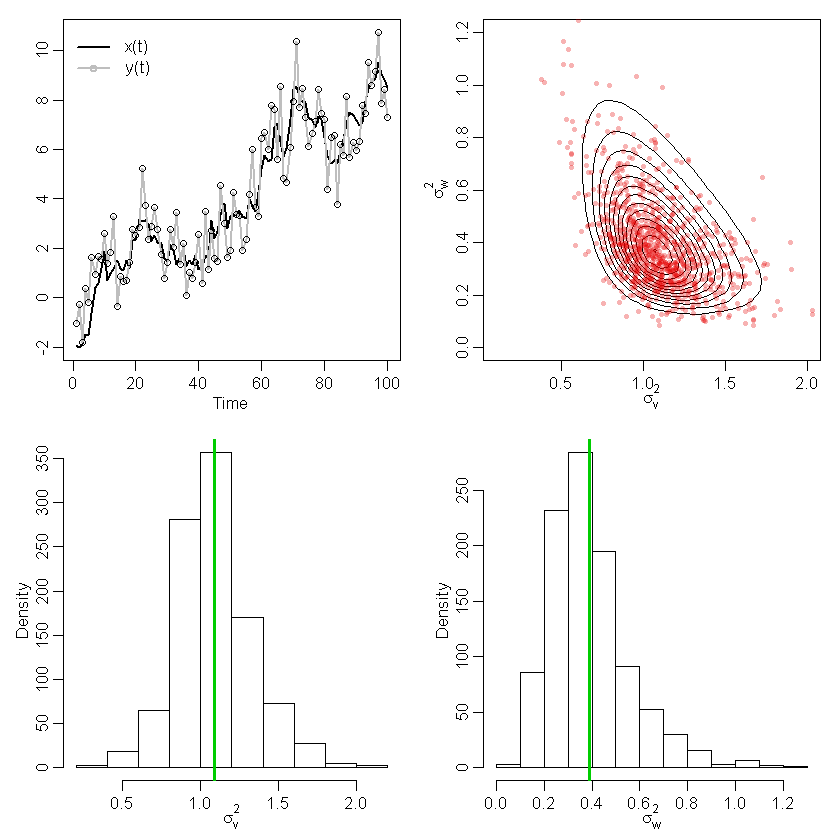

In [1]:
##-- Notation --##
# y(t) = x(t) + v(t); v(t) ~ iid N(0,V)
# x(t) = x(t-1) + w(t); w(t) ~ iid N(0,W)
# priors: x(0) ~ N(m0,C0); V ~ IG(a,b); W ~ IG(c,d)
# FFBS: x(t|t) ~ N(m,C); x(t|n) ~ N(mm,CC); x(t|t+1) ~ N(a,R)
##--
require(astsa)
# y=측정값, V=측정잡음분산, W=상태잡음분산, m0=사전모델평균, C0=사전모델분산
ffbs = function(y,V,W,m0,C0){ 
# n=데이터 개수, a=x(t|t+1)의 평균, R=x(t|t+1)의 분산=Kalman Filter에서 P 
n = length(y); a = rep(0,n); R = rep(0,n)
# m=x(t|t)의 평균, C=x(t|t)의 분산, B=?     
m = rep(0,n); C = rep(0,n); B = rep(0,n-1)
# H=?, mm=x(t|n)의 평균, CC=x(t|n)의 분산     
H = rep(0,n-1); mm = rep(0,n); CC = rep(0,n)
# x=상태, llike = ?
x = rep(0,n); llike = 0.0
for (t in 1:n){
if(t==1){a[1] = m0;  R[1] = C0 + W;  # State Prediction & Covariance Prediction 
}else{ a[t] = m[t-1]; R[t] = C[t-1] + W }
f = a[t]
Q = R[t] + V    # (A_t P_t^{t-1} A_t'+R)
A = R[t]/Q      # Kalman Gain K=P_t^{t-1}A_t'[A_t P_t^{t-1} A_t'+R]^{-1}
m[t] = a[t]+A*(y[t]-f) # State Estimation
C[t] = R[t]-Q*A**2     # Error Covariance Estimation
B[t-1] = C[t-1]/R[t]
H[t-1] = C[t-1]-R[t]*B[t-1]**2
llike = llike + dnorm(y[t],f,sqrt(Q),log=TRUE) }
mm[n] = m[n]; CC[n] = C[n]
x[n] = rnorm(1,m[n],sqrt(C[n]))
for (t in (n-1):1){
mm[t] = m[t] + C[t]/R[t+1]*(mm[t+1]-a[t+1])
CC[t] = C[t] - (C[t]^2)/(R[t+1]^2)*(R[t+1]-CC[t+1])
x[t] = rnorm(1,m[t]+B[t]*(x[t+1]-a[t+1]),sqrt(H[t])) }
return(list(x=x,m=m,C=C,mm=mm,CC=CC,llike=llike)) }
# Simulate states and data
set.seed(1); W = 0.5; V = 1.0
n = 100; m0 = 0.0; C0 = 10.0; x0 = 0
w = rnorm(n,0,sqrt(W))
v = rnorm(n,0,sqrt(V))
x = y = rep(0,n)
x[1] = x0 + w[1]
y[1] = x[1] + v[1]
for (t in 2:n){
x[t] = x[t-1] + w[t]
    y[t] = x[t] + v[t] }
# actual smoother (for plotting)
ks = Ksmooth0(num=n, y, A=1, m0, C0, Phi=1, cQ=sqrt(W), cR=sqrt(V))
xsmooth = as.vector(ks$xs)
#
run = ffbs(y,V,W,m0,C0)
m = run$m; C = run$C; mm = run$mm
CC = run$CC; L1 = m-2*C; U1 = m+2*C
L2 = mm-2*CC; U2 = mm+2*CC
N = 50
Vs = seq(0.1,2,length=N)
Ws = seq(0.1,2,length=N)
likes = matrix(0,N,N)
for (i in 1:N){
for (j in 1:N){
V = Vs[i]
W = Ws[j]
run = ffbs(y,V,W,m0,C0)
likes[i,j] = run$llike } }
# Hyperparameters
a = 0.01; b = 0.01; c = 0.01; d = 0.01
# MCMC step
set.seed(90210)
burn = 10; M = 1000
niter = burn + M
V1 = V; W1 = W
draws = NULL
all_draws = NULL
for (iter in 1:niter){
run = ffbs(y,V1,W1,m0,C0)
x = run$x
V1 = 1/rgamma(1,a+n/2,b+sum((y-x)^2)/2)
W1 = 1/rgamma(1,c+(n-1)/2,d+sum(diff(x)^2)/2)
draws = rbind(draws,c(V1,W1,x)) }
all_draws = draws[,1:2]
q025 = function(x){quantile(x,0.025)}
q975 = function(x){quantile(x,0.975)}
draws = draws[(burn+1):(niter),]
xs = draws[,3:(n+2)]
lx = apply(xs,2,q025)
mx = apply(xs,2,mean)
ux = apply(xs,2,q975)
## plot of the data
par(mfrow=c(2,2), mgp=c(1.6,.6,0), mar=c(3,3.2,1,1))
ts.plot(ts(x), ts(y), ylab='', col=c(1,8), lwd=2)
points(y)
legend(0, 11, legend=c("x(t)","y(t)"), lty=1, col=c(1,8), lwd=2, bty="n",
pch=c(-1,1))
contour(Vs, Ws, exp(likes), xlab=expression(sigma[v]^2),
ylab=expression(sigma[w]^2), drawlabels=FALSE, ylim=c(0,1.2))
points(draws[,1:2], pch=16, col=rgb(.9,0,0,0.3), cex=.7)
hist(draws[,1], ylab="Density",main="", xlab=expression(sigma[v]^2))
abline(v=mean(draws[,1]), col=3, lwd=3)
hist(draws[,2],main="", ylab="Density", xlab=expression(sigma[w]^2))
abline(v=mean(draws[,2]), col=3, lwd=3)

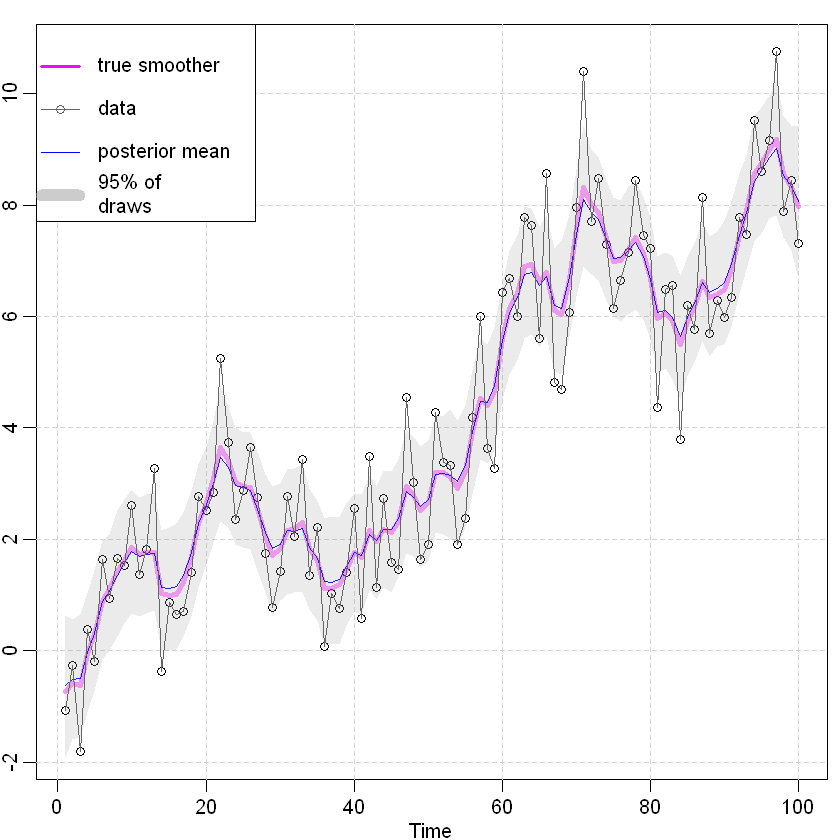

In [2]:
## plot states
par(mgp=c(1.6,.6,0), mar=c(2,1,.5,0)+.5)
plot(ts(mx), ylab='', type='n', ylim=c(min(y),max(y)))
grid(lty=2); points(y)
lines(xsmooth, lwd=4, col=rgb(1,0,1,alpha=.4))
lines(mx, col= 4)
xx=c(1:100, 100:1)
yy=c(lx, rev(ux))
polygon(xx, yy, border=NA, col= gray(.6,alpha=.2))
lines(y, col=gray(.4))
legend('topleft', c('true smoother', 'data', 'posterior mean', '95% of
draws'), lty=1, lwd=c(3,1,1,10), pch=c(-1,1,-1,-1), col=c(6,
gray(.4) ,4, gray(.6, alpha=.5)), bg='white' )


다음으로 더 복잡한 모델을 고려해 봅시다.

### 예제 6.27 구조 모델

예제 6.10에서 다루었던 존슨 앤 존슨의 분기별 수익을 고려해 봅시다. 모델은 다음과 같습니다.

$$y_t=\begin{pmatrix}
1 && 1 && 0 && 0
\end{pmatrix}
x_t+v_t$$

$$x_t=\begin{pmatrix}
T_t \\ S_t \\ S_{t-1} \\ S_{t-2}
\end{pmatrix}
=
\begin{pmatrix}
\phi && 0 && 0 && 0 \\
0 && -1 && -1 && -1 \\
0 && 1 && 0 && 0 \\
0 && 0 && 1 && 0 \\
\end{pmatrix}
+
\begin{pmatrix}
w_{t1} \\ w_{t2} \\ 0 \\ 0
\end{pmatrix}$$

여기서 $R=\sigma_v^2$이고,

$$Q=\begin{pmatrix}
\sigma_{w,11}^2 && 0 && 0 && 0 \\
0 && \sigma_{w,22}^2 && 0 && 0 \\
0 && 0 && 0 && 0 \\
0 && 0 && 0 && 0 \\
\end{pmatrix}$$

성장률과 관련된 ($\phi>1$) 전이 변수, 관측 잡음 분산 $\sigma_v^2$, 트렌드 및 주기성 성분과 관련된 상태 잡음 분산 $\sigma_{w,11}^2$, $\sigma_{w,22}^2$을 추정해야 합니다.

이 경우, $p(x_{0:n}|\Theta,y_{1:n})$으로 부터 샘플링 하는 것은 (6.217), (6.218)에 따라 수행됩니다. 다음으로 $p(x_{0:n}|\Theta,y_{1:n})$으로 부터 샘플링을 어떻게 할 것인지에 대해 논의해 보겠습니다. 전이 변수의 경우 $\phi=1+\beta$, $0<\beta<<1$로 표기하고, 예제 6.10을 상기해 볼 때 $\phi$는 $1.035$로 추정되었습니다. 이는 $3.5%$의 성장률 $\beta$를 의미합니다. 트랜드 성분은 다음과 같이 쓸 수 있습니다.

$$\nabla T_t=T_t-T_{t-1}=\beta T_{t-1}+w_{t1}$$

결과적으로 변수 $\beta$는 $t=1,\dots,n$에서 $T_{t-1}$의 $\nabla T_t$에 대한 선형 회기 결과의 기울기 이고, $w_{t1}$는 오차입니다. 전형적인 방법으로 $(\beta,\sigma_{w,11}^2)$에 대하여 정규 역감마(IG) 사전 분포를 적용하겠습니다. 즉, 초매개변수 $b_0, B_0, n_0, s_0^2$들을 알고 있는 상황에서 $\beta|\sigma_{w,11}^2 \sim N(b_0,\sigma_{w,11}^2B_0)$, $\sigma_{w,11}^2\sim IG(n_0/2, n_0 s_0^2/2)$ 입니다.

두개의 분산 성분인 $\sigma_v^2$, $\sigma_{w,22}^2$에 대해서도 IG를 사전 분포로 사용하겠습니다.

이 경우, 사전분포가 $\sigma_v^2 \sim IG(n_0/2, n_0s_0^2/2)$이면, 사후 분포는 다음과 같습니다.

$$\sigma_v^2|x_{0:n}, y_{1:n} \sim IG(n_v/2,n_vs_v^2/2)$$

여기서 $n_v=n_0+n$, $n_vs_v^2=n_0s_0^2+\sum_{t=1}^{n}(Y_t-T_t-S_t)^2$입니다.

이와 유사하게, 만약 사전분포가 $\sigma_{w,22}^2\sim IG(n_0/2,n_0s_0^2/2)$이면, 사후 분포는 다음과 같습니다.

$$\sigma_{w,22}^2|x_{0:n}, y_{1:n} \sim IG(n_w/2, n_w s_w^2/2)$$

여기서 $n_w=n_0+(n-3)$이고, $n_ws_w^2=n_0s_0^2+\sum_{t=1}^{n-3}(S_t-S_{t-1}-S_{t-2}-S_{t-3})^2$입니다.

그림 6.22는 변수들의 사후 추정치를 보여줍니다. 상단 그림은 100개의 burn-in 과정 이후의 1000개 추출 결과를 보여주며, 스텝의 크기는 10로 설정되었습니다. (즉, 매 10번째 샘플이 포함됨) 중간 그림은 사후 추정치의 ACF를 보여주며, 샘플된 사후 값들은 아래 그림에 나타나 있습니다. 이 결과는 예제 6.10의 결과와 비교할 수 있습니다. 사후 평균 및 중간 값은 3.7%의 성장률을 보입니다.

그림 6.23은 트렌드 $(T_t)$와 주기성분($T_t+S_t$)에 대해 99%의 신뢰 구간으로 스무딩한 결과를 보여줍니다. 이 결과들도 예제 6.10의 결과와 비교할 수 있습니다. 이 예제의 R Code는 다음과 같습니다.

In [18]:
require(astsa)
library(plyr) # used to view progress (install it if you don't have it)

y = jj
### setup - model and initial parameters
set.seed(90210)
n = length(y)
F = c(1,1,0,0) # this is A
G = diag(0,4) # G is Phi
G[1,1] = 1.03
G[2,] = c(0,-1,-1,-1); G[3,]=c(0,1,0,0); G[4,]=c(0,0,1,0)
a1 = rbind(.7,0,0,0) # this is mu0
R1 = diag(.04,4) # this is Sigma0
V = .1
W11 = .1
W22 = .1
##-- FFBS --##
ffbs = function(y,F,G,V,W11,W22,a1,R1){
n = length(y)
Ws = diag(c(W11,W22,1,1)) # this is Q with 1s as a device only
iW = diag(1/diag(Ws),4)
a = matrix(0,n,4) # this is m_t
R = array(0,c(n,4,4)) # this is V_t
m = matrix(0,n,4)
C = array(0,c(n,4,4))
a[1,] = a1[,1]
R[1,,] = R1
f = t(F)%*%a[1,]
Q = t(F)%*%R[1,,]%*%F + V
A = R[1,,]%*%F/Q[1,1]
m[1,] = a[1,]+A%*%(y[1]-f)
C[1,,] = R[1,,]-A%*%t(A)*Q[1,1]
for (t in 2:n){
a[t,] = G%*%m[t-1,]
R[t,,] = G%*%C[t-1,,]%*%t(G) + Ws
f = t(F)%*%a[t,]
Q = t(F)%*%R[t,,]%*%F + V
A = R[t,,]%*%F/Q[1,1]
m[t,] = a[t,] + A%*%(y[t]-f)
C[t,,] = R[t,,] - A%*%t(A)*Q[1,1] }
xb = matrix(0,n,4)
xb[n,] = m[n,] + t(chol(C[n,,]))%*%rnorm(4)
for (t in (n-1):1){
iC = solve(C[t,,])
CCC = solve(t(G)%*%iW%*%G + iC)
mmm = CCC%*%(t(G)%*%iW%*%xb[t+1,] + iC%*%m[t,])
xb[t,] = mmm + t(chol(CCC))%*%rnorm(4) }
return(xb) }
##-- Prior hyperparameters --##
# b0 = 0 # mean for beta = phi -1
# B0 = Inf # var for beta (non-informative => use OLS for sampling beta)
n0 = 10 # use same for all- the prior is 1/Gamma(n0/2, n0*s20_/2)
s20v = .001 # for V
s20w =.05 # for Ws
##-- MCMC scheme --##
set.seed(90210)
burnin = 100
step = 10
M = 1000
niter = burnin+step*M
pars = matrix(0,niter,4)
xbs = array(0,c(niter,n,4))
pr <- progress_text() # displays progress
pr$init(niter)
for (iter in 1:niter){
xb = ffbs(y,F,G,V,W11,W22,a1,R1)
u = xb[,1]
yu = diff(u); xu = u[-n] # for phihat and se(phihat)
regu = lm(yu~0+xu) # est of beta = phi-1
phies = as.vector(coef(summary(regu)))[1:2] + c(1,0) # phi estimate and SE
dft = df.residual(regu)
G[1,1] = phies[1] + rt(1,dft)*phies[2] # use a t
V = 1/rgamma(1, (n0+n)/2, (n0*s20v/2) + sum((y-xb[,1]-xb[,2])^2)/2)
W11 = 1/rgamma(1, (n0+n-1)/2, (n0*s20w/2) +
sum((xb[-1,1]-phies[1]*xb[-n,1])^2)/2)
W22 = 1/rgamma(1, (n0+ n-3)/2, (n0*s20w/2) + sum((xb[4:n,2] +
xb[3:(n-1),2]+ xb[2:(n-2),2] +xb[1:(n-3),2])^2)/2)
xbs[iter,,] = xb
pars[iter,] = c(G[1,1], sqrt(V), sqrt(W11), sqrt(W22))
pr$step() }
# Plot results
ind = seq(burnin+1,niter,by=step)
names= c(expression(phi), expression(sigma[v]), expression(sigma[w~11]),
expression(sigma[w~22]))
dev.new(height=5)
par(mfcol=c(3,4), mar=c(2,2,.25,0)+.75, mgp=c(1.6,.6,0), oma=c(0,0,1,0))
for (i in 1:4){
plot.ts(pars[ind,i],xlab="iterations", ylab="trace", main="")
mtext(names[i], side=3, line=.5, cex=1)
acf(pars[ind,i],main="", lag.max=25, xlim=c(1,25), ylim=c(-.4,.4))
hist(pars[ind,i],main="",xlab="")
abline(v=mean(pars[ind,i]), lwd=2, col=3) }
par(mfrow=c(2,1), mar=c(2,2,0,0)+.7, mgp=c(1.6,.6,0))
mxb = cbind(apply(xbs[ind,,1],2,mean), apply(xbs[,,2],2,mean))
lxb = cbind(apply(xbs[ind,,1],2,quantile,0.005),
apply(xbs[ind,,2],2,quantile,0.005))
uxb = cbind(apply(xbs[ind,,1],2,quantile,0.995),
apply(xbs[ind,,2],2,quantile,0.995))
mxb = ts(cbind(mxb,rowSums(mxb)), start = tsp(jj)[1], freq=4)
lxb = ts(cbind(lxb,rowSums(lxb)), start = tsp(jj)[1], freq=4)
uxb = ts(cbind(uxb,rowSums(uxb)), start = tsp(jj)[1], freq=4)
names=c('Trend', 'Season', 'Trend + Season')
L = min(lxb[,1])-.01; U = max(uxb[,1]) +.01
plot(mxb[,1], ylab=names[1], ylim=c(L,U), type='n')
grid(lty=2); lines(mxb[,1])
xx=c(time(jj), rev(time(jj)))
yy=c(lxb[,1], rev(uxb[,1]))
polygon(xx, yy, border=NA, col=gray(.4, alpha = .2))
L = min(lxb[,3])-.01; U = max(uxb[,3]) +.01
plot(mxb[,3], ylab=names[3], ylim=c(L,U), type='n')
grid(lty=2); lines(mxb[,3])
xx=c(time(jj), rev(time(jj)))
yy=c(lxb[,3], rev(uxb[,3]))
polygon(xx, yy, border=NA, col=gray(.4, alpha = .2))

Loading required package: astsa
Warning message:
"package 'astsa' was built under R version 3.6.3"

  |======================================================================| 100%